# 1. Starter code

In [1]:
%matplotlib notebook
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

### Figure drawing

In [2]:
def plot_pmf(ax, items, nbins=10, alpha=0.5, c=None):
    bins = np.linspace(np.min(items), np.max(items)+1, nbins+1)
    if(np.max(items) <= 1):
        bins = np.linspace(np.min(items), np.max(items)+.001, nbins+1)
    counts, _ = np.histogram(items, bins)
    width = (bins[1]-bins[0])*0.8
    if c is not None:
        ax.bar(bins[:-1], counts/items.shape[0], width=width, align='edge',alpha=alpha, color=c)
    else:
        ax.bar(bins[:-1], counts/items.shape[0], width=width, align='edge',alpha=alpha)
    
def setup_figure(sample, orig_stat):
    fig = plt.figure(figsize=(5,3))
    ax = plt.gca()
    plot_pmf(ax, sample)
    ax.axvline(orig_stat, label='resampled means')
    ax.axvline(orig_stat, label='original sample mean', color='orange')
    fig.legend()
    fig.canvas.draw()
    time.sleep(2)
    return (fig, ax)

def update_figure(f_ax, stat):
    fig, ax = f_ax
    ax.axvline(stat, alpha=0.5)
    fig.canvas.draw()
    time.sleep(.5)

def plot_compare(bootstrapped_means, sample, population):
    fig, axs = plt.subplots(1,3, figsize=(7,2))
    bootstrapped_means = np.array(bootstrapped_means)
    plot_pmf(axs[0], bootstrapped_means)
    axs[0].axvline(np.mean(sample), label='sample', color='orange')
    axs[0].axvline(np.mean(population), label='population', color='r')
    axs[0].set_yticklabels([str('%.1f' % x)[1:] for x in axs[0].get_yticks()])
    axs[0].set_title('Bootstrapped means')
    axs[0].set_ylabel('PMF')

    plot_pmf(axs[1], sample, alpha=1.0)
    axs[1].axvline(np.mean(sample), color='orange')
    axs[1].axvline(np.mean(population), color='r')
    axs[1].set_yticklabels([str('%.2f' % x)[1:] for x in axs[1].get_yticks()])
    axs[1].set_title('Original Sample')

    plot_pmf(axs[2], population, alpha=1.0)
    axs[2].axvline(np.mean(population), color='r')
    axs[2].set_title('Population')
    axs[2].set_yticklabels([str('%.2f' % x)[1:] for x in axs[2].get_yticks()])
    fig.tight_layout()
    fig.legend(loc='lower right')
    
def plot_initial(sample, population, title=None, c=None, compare_keep=True):
    fig, axs = plt.subplots(1,2, figsize=(7.5,3))
    plot_pmf(axs[0], sample, alpha=1.0, c=c)
    axs[0].set_ylabel('Sample PMF (count/sample_size)')
    axs[0].set_title('Sample distribution')
    axs[0].axvline(np.mean(sample), label='sample', color='red')
    if compare_keep: axs[0].axvline(np.mean(population), color='orange')
    plot_pmf(axs[1], population, alpha=1.0, c=c)
    axs[1].set_ylabel('Population PMF (count/9999)')
    axs[1].set_title('Population distribution')
    axs[1].axvline(np.mean(population), label='population', color='orange')
    if compare_keep: axs[1].axvline(np.mean(sample), color='red')
    fig.legend(loc='lower right')
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title)
    plt.show()

### Functions to generate populations

In [3]:
# some random variables
from scipy.stats import uniform
def uniform_rv(a, b):
    return lambda n: uniform.rvs(a, b, size=n)

def multinomial_rv(ub):
    return lambda n: np.random.randint(1, ub+1, size=n)

from scipy.stats import expon
def exp_rv(lam):
    return lambda n: expon.rvs(lam,size=n).astype(int)

from scipy.stats import beta
def beta_rv(a, b):
    return lambda n: beta.rvs(a, b, size=n)

In [4]:
def get_population(rv_maker, population_size):
    population = rv_maker(population_size)
    return population

def get_sample(population, sample_size):
    return np.random.choice(population, size=sample_size, replace=True)

class PMF(object):
    def __init__(self, distribution):
        self.distribution = distribution
        
    def sample(self, size=10):
        return np.random.choice(self.distribution, size=size)

# 2. Bootstrapped confidence intervals

The speed statistics for Water Pokemon are thanks to the Kaggle Dataset [Pokemon with stats](https://www.kaggle.com/abcsds/pokemon/data).

### Water Pokemon population

<IPython.core.display.Javascript object>


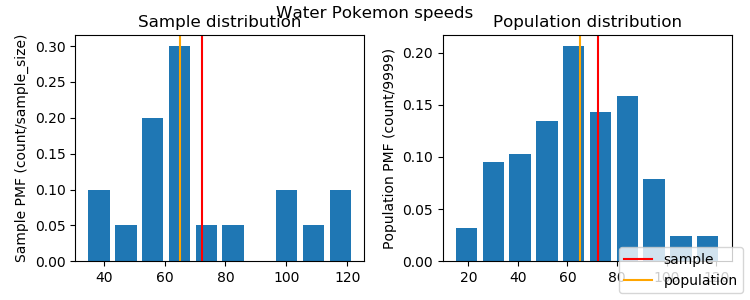

sample mean 72.3
population mean 64.98412698412699


In [5]:
with open(os.path.join('csvs', 'water_speed.csv'), 'r') as f:
    water_speeds = [float(line.strip()) for line in f.readlines()]
population = np.array(water_speeds)
sample = get_sample(water_speeds, 20)
plot_initial(sample, population, 'Water Pokemon speeds')

print('sample mean', np.mean(sample))
print('population mean', np.mean(population))

In [6]:
def histogram_count(sample):
    return PMF(sample)

def compute_stat(sample):
    return np.average(sample)

def bootstrap(sample, num_samples=10000, anim=False):
    pmf = histogram_count(sample)
    if anim: # plot with animation
        f_ax = setup_figure(sample, compute_stat(sample))
    results = []
    for i in range(num_samples):
        resample = pmf.sample(size=len(sample))
        stat = compute_stat(resample) # sample mean
        if anim: update_figure(f_ax, stat) # plot
        results.append(stat)
    return results # distribution of sample means

## Bootstrap step by step

<IPython.core.display.Javascript object>


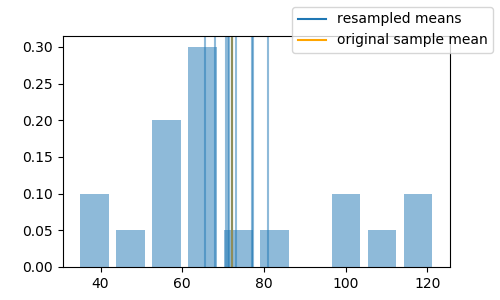

In [7]:
bootstrapped_means = bootstrap(sample, num_samples=10, anim=True)

## Bootstrap for real

<IPython.core.display.Javascript object>


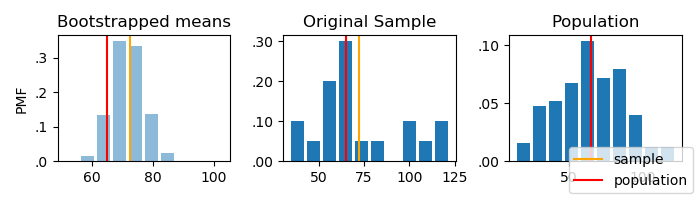

sample mean 72.3
population mean 64.98412698412699


In [8]:
bootstrapped_means = bootstrap(sample, num_samples=100000, anim=False)
plot_compare(bootstrapped_means, sample, population)
print('sample mean', np.mean(sample))
print('population mean', np.mean(population))

# Computing bootstrapped statistics of the sample mean


## Q1: What is the bootstrapped SE, and how does this compare to the SE from the original sample mean?
* Population mean: \\( \mu \\), population variance: \\( \sigma^2 \\)
* Sample mean: \\(\bar{X} \\) = ```np.mean(sample)```, where \\( E[\bar{X}] = \mu \\)
* Sample variance: \\( S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2 \\), where \\( E[S^2] = \sigma^2 \\)
* ```stats.sem(sample)```: computes the standard error of the items, \\( SE = \sqrt{\frac{S^2}{n}} = \frac{S}{\sqrt{n}} \\)

In [9]:
print('Sample mean {}, standard error {}'.format('%.2f' % np.mean(sample), '%.2f' % stats.sem(sample)))
print('Bootstrapped standard error {}'.format('%.2f' % np.std(bootstrapped_means)))
print('Population mean {}'.format('%.2f' % np.mean(population)))

Sample mean 72.30, standard error 5.36
Bootstrapped standard error 5.21
Population mean 64.98


## Q2:  What is the confidence interval associated with the belief that the population mean is within ±1 bootstrapped SE of the sample mean?

In [10]:
"""
Computes the % of bootstrapped sample means
that are within the specified interval of (sample_mean) +/- pm*boot_se.

bootstrapped_means:  bootstrapped sample statistics
sample:              original sample
pop_mean:            known population mean for comparison
pm:                  number of bootstrapped errors over which to
                       compute confidence interval
"""
def confidence_interval(bootstrapped_means, sample, pop_mean, pm):
    count = 0
    boot_steps = np.array(bootstrapped_means).shape[0]
    boot_se = np.std(bootstrapped_means)
    sample_mean = np.mean(sample)
    interval_lb = sample_mean - pm*boot_se # confidence interval lower-bound
    interval_ub = sample_mean + pm*boot_se # confidence interval upper-bound
    
    for x in bootstrapped_means:
        if x > interval_lb and x < interval_ub:
            count +=1
    print('Bootstrapped standard error {}'.format('%.2f' % boot_se))
    print('{}% confidence that pop. mean is within ({}, {})'.format(
        '%.2f' % (100*count/boot_steps),
        '%.2f' % (interval_lb),
        '%.2f' % (interval_ub)))
    print('Original sample mean {}'.format('%.2f' % sample_mean))
    print('Population mean {}'.format('%.2f' % pop_mean))

In [11]:
confidence_interval(bootstrapped_means, sample, np.mean(population), pm=1.96)

Bootstrapped standard error 5.21
95.14% confidence that pop. mean is within (62.08, 82.52)
Original sample mean 72.30
Population mean 64.98
